In [514]:

import pandas as pd
import numpy as np
import datetime as dt
import pickle
import quandl
import datetime as dt
#import Quantlib
import mibian as mb
import os
from numba import jit
import zipfile

import seaborn
import calendar
from sklearn import preprocessing
%matplotlib inline
import xlrd as xlrd
#from cvxopt import matrix, solvers

us_r = pd.read_csv(r'C:/Users/user/Desktop/US HY/iss_r.csv')
us_s = pd.read_csv(r'C:/Users/user/Desktop/US HY/iss_s.csv')
us_w = pd.read_csv(r'C:/Users/user/Desktop/US HY/iss_w.csv')
bid=pd.read_csv(r'C:/Users/user/Desktop/US HY/bid.csv')
ask=pd.read_csv(r'C:/Users/user/Desktop/US HY/ask.csv')
oas=pd.read_csv(r'C:/Users/user/Desktop/US HY/oas.csv')
btr=pd.read_csv(r'C:/Users/user/Desktop/US HY/btr.csv')
volume = pd.read_csv(r'C:/Users/user/Desktop/US HY/volume.csv')


roa= pd.read_csv(r'C:/Users/user/Desktop/US HY/roa.csv')
binf=pd.read_csv(r'C:/Users/user/Desktop/US HY/binf.csv')

us_r.index = [dt.datetime.strptime(x,'%Y-%m-%d') for x in us_r['Unnamed: 0']]
us_s.index = [dt.datetime.strptime(x,'%Y-%m-%d') for x in us_s['Unnamed: 0']]
us_w.index = [dt.datetime.strptime(x,'%Y-%m-%d') for x in us_w['Unnamed: 0']]
volume.index = [dt.datetime.strptime(x,'%Y-%m-%d') for x in volume['Unnamed: 0']]
roa.index = [dt.datetime.strptime(x,'%m/%d/%Y') for x in roa['Unnamed: 0']]
bid.index = [dt.datetime.strptime(x,'%Y-%m-%d') for x in bid['Unnamed: 0']]
ask.index = [dt.datetime.strptime(x,'%Y-%m-%d') for x in ask['Unnamed: 0']]
oas.index = [dt.datetime.strptime(x,'%Y-%m-%d') for x in oas['Unnamed: 0']]
btr.index = [dt.datetime.strptime(x,'%Y-%m-%d') for x in btr['Unnamed: 0']]


del us_r['Unnamed: 0']
del us_s['Unnamed: 0']
del us_w['Unnamed: 0']
del roa['Unnamed: 0']
del volume['Unnamed: 0']
del bid['Unnamed: 0']
del ask['Unnamed: 0']
del oas['Unnamed: 0']
del btr['Unnamed: 0']



volume=volume.fillna(0)


In [509]:


bond_stock_ticker=binf[["Eqty.Ticker",'iss']].drop_duplicates(['iss'], keep='last')
reb_date=(np.append(0,np.diff(us_r.index.month))!=0) & us_r.index.month.isin([4,7,1])
us_roa=pd.DataFrame(np.nan, index=roa.index, columns=list(us_s))
roa_temp=bond_stock_ticker.index[bond_stock_ticker['Eqty.Ticker'].isin(list(roa))]
roa_ticks=bond_stock_ticker.loc[roa_temp,'Eqty.Ticker'].tolist()
us_roa[bond_stock_ticker.loc[roa_temp,'iss'].tolist()]=roa[roa_ticks]
vol2w=volume.rolling(window=10,center=False).sum()
cond=(np.isnan(bid)==False)& (np.isnan(ask)==False) & (np.isnan(oas)==False) & (vol2w>0)




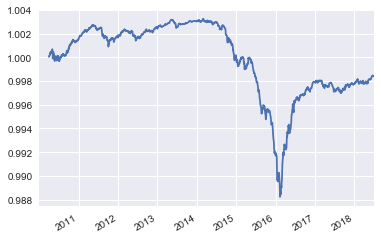

In [542]:
dates=us_r.index
us_pos = us_r.copy() * np.nan
us_bond_pos=bid.copy() * np.nan
day_i = us_r.index[0]
for ii,day_i in enumerate(dates[:-3]):
    if reb_date[ii+1]:
        us_pos.loc[dates[ii+1],:]=0
        us_bond_pos.loc[dates[ii+1],:]=0
        order_roa=us_roa.loc[(us_roa.index<=dates[ii+1]) & ((dates[ii+1]-us_roa.index).days<6)].nlargest(1,list(us_roa)).T.iloc[:,0].nsmallest(20)     
        for tick in order_roa.index.tolist():
            if any(cond.loc[day_i,binf.loc[binf["iss"]==tick,"is"]]):
              #  print("wow")
                bond_to_buy=vol2w.loc[day_i,binf.loc[binf["iss"]==tick,"is"]].nlargest(1).index
                us_bond_pos.loc[dates[ii+1],bond_to_buy]=1
      
        us_pos.loc[dates[ii+1],order_roa.index.tolist()] = 1
        
us_pos = us_pos.ffill()
us_bond_pos = us_bond_pos.ffill()


ba=abs(us_bond_pos.diff())*(bid/ask-1)
(us_bond_pos * (btr+ba)).mean(axis=1).add(1).cumprod().plot()#(figsize=[12,9])
